In [ ]:
# Celda 1: Importación de Librerías
# Esta celda importa las librerías principales de TensorFlow y Keras, incluyendo las capas necesarias para construir la arquitectura del Transformer.

# Importacion de Librerias
import tensorflow as tf                     # Librería principal para aprendizaje automático.
from keras.models import Sequential, Model  # Sequential para modelos en cascada, Model para modelos con múltiples entradas/salidas (funcional API).
import numpy as np                          # Utilizada para operaciones numéricas y manejo de arrays de datos.
from keras.utils import pad_sequences       # Función para estandarizar la longitud de las secuencias.
from sklearn.model_selection import train_test_split # Utilizada para dividir el dataset en conjuntos de entrenamiento y validación.
# Capas de la red: Dense, Embedding, Input (para Functional API), Attention (clave del Transformer), Flatten.
from keras.layers import Dense, Embedding, Input, Attention, Flatten 
import string                               # Módulo para manejo de cadenas de texto (e.g., puntuación).
import datetime                             # Utilizada para manejo de fechas y generación de tags.
import nltk                                 # Toolkit para el procesamiento del lenguaje natural (NLP).
from nltk.tokenize import sent_tokenize,word_tokenize # Funciones de NLTK para tokenizar texto en oraciones y palabras.

In [ ]:
#Celda 2: Carga del Dataset
#Esta celda abre el archivo del dataset de mensajes SMS.

# Carga del archivo del dataset (se asume que 'sms.txt' está disponible en el mismo directorio)
dataset = open("sms.txt")

In [ ]:

# Celda 3: Tokenización, Limpieza y Conteo de Vocabulario
# Esta celda procesa los mensajes, realiza la limpieza de puntuación, tokeniza en palabras y construye el vocabulario, asignando una etiqueta binaria.

# Descarga de recursos de NLTK si no están presentes (necesarios para la tokenización)
nltk.download('punkt')
nltk.download('punkt_tab')

X=[] # Lista para almacenar los mensajes de texto (secuencias de palabras).
Y=[] # Lista para almacenar las etiquetas de clase (0 para 'ham', 1 para 'spam').
vocabulario={} # Diccionario para llevar el conteo de frecuencia de cada palabra.

# Generador de tabla de traducción para eliminar la puntuación.
translator = str.maketrans(dict.fromkeys(string.punctuation))

# Itera sobre cada línea del archivo dataset
for linea in dataset:
    # Separa la etiqueta ('spam' o 'ham') del texto del mensaje
    label,text=linea.strip().split("\t")
    
    # Elimina la puntuación del texto
    text=text.translate(translator)
    
    message=[] # Lista temporal para las palabras del mensaje actual
    
    # Tokeniza el texto en oraciones y luego en palabras
    for i in sent_tokenize(text):
        for j in word_tokenize(i):
            palabra=j.lower() # Convierte la palabra a minúsculas
            message.append(palabra)
            
            # Conteo de frecuencia de palabras para construir el vocabulario
            if palabra in vocabulario:
                vocabulario[palabra]+=1
            else:
                vocabulario[palabra]=1
    
    X.append(message) # Agrega la lista de palabras del mensaje a X
    
    # Asigna la etiqueta numérica: [1] si es "spam", [0] si es "ham"
    y=[1] if label=="spam" else [0]
    Y.append(y)

# Imprime el tamaño del vocabulario (cantidad de palabras únicas)
print(len(vocabulario.keys()))

9636


In [ ]:
# Celda 4: Importación del Tokenizador de Keras
# Se importa la herramienta Tokenizer de Keras para la indexación de palabras.

# Importa la clase Tokenizer de Keras para preprocesamiento de texto
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
# Celda 5: Ajuste e Indexación de Keras Tokenizer
# Esta celda ajusta el Tokenizer de Keras a los datos y convierte las secuencias de palabras en secuencias de índices numéricos (tokens).

# Inicializa el objeto Tokenizer de Keras
tokenizer = Tokenizer()

# Ajusta el tokenizer a los textos para construir el índice de palabras
tokenizer.fit_on_texts(X)

# Convierte las listas de palabras (X) en listas de índices numéricos
sequences = tokenizer.texts_to_sequences(X)

In [ ]:
# Celda 6: Extracción y Conteo Final de Vocabulario
# Se calcula el tamaño final del vocabulario, que incluye el índice 0 para padding.

# words=list(tokenizer.word_index.keys())
# print(words)
# vocabulary=len(words)+1
# print(len(vocabulario.keys()))

# Obtiene la lista ordenada de palabras según el índice de Keras Tokenizer
words=list(tokenizer.word_index.keys())
print(words)

# Define el tamaño del vocabulario (+1 porque Keras reserva el índice 0 para padding)
vocabulary=len(words)+1
print(len(vocabulario.keys()))
print(vocabulary)

NameError: name 'tokenizer' is not defined

In [ ]:
# Celda 7: Relleno de Secuencias (Padding)
# Se utiliza pad_sequences para estandarizar la longitud de todos los mensajes

# Rellena las secuencias para que todas tengan la misma longitud.
# La longitud se determina automáticamente por la secuencia más larga.
X = pad_sequences(sequences)

In [ ]:
#Celda 8: Verificación de la Forma del Dataset (Shape)
#Se verifica la forma del conjunto de datos X después del padding.

# Muestra la forma (número de muestras, longitud máxima de secuencia) del dataset X
X.shape

In [ ]:
# Celda 9: Preparación de Variables para el Modelo
# Se establece la longitud de entrada y se convierten los conjuntos X e Y a arrays de NumPy.

# La longitud de entrada es el largo de la primera secuencia (longitud máxima, 171)
input_length=len(X[0])

# Imprime el tamaño del vocabulario y la longitud de entrada máxima
print(vocabulary,input_length)

# Convierte las listas X e Y a arrays de NumPy, requisito para el entrenamiento
X=np.asarray(X)
Y=np.asarray(Y)



9637 171


In [ ]:
# Celda 10: División en Conjuntos de Entrenamiento y Validación
# Se utiliza train_test_split para separar los datos en conjuntos de entrenamiento (80%) y validación (20%), estratificando por la etiqueta Y.

# Divide los datos en entrenamiento (80%) y validación (20%)
# stratify=Y asegura la proporción de clases.
# random_state=1 asegura que la división sea reproducible.
x_train,x_val,y_train,y_val=train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=1)


Una vez que tenemos la secuencia de mensajes, el primer paso es crear un embedding que cree una representación vectorial de cada palabra de cada mensaje. Luego de eso agregamos la operación de atención. Esta
operación se caracteriza por analizar una secuencia candidata (el query: q) y compararla con un grupo de secuencias (las claves: k) y a partir de la similaridad de cada clave con secuencia candidata, genera como salida
una combinación lineal de los valores asociados a cada clave (cada clave k tiene asociado un vector de valor, v). Hay muchos tipos de antención, en este ejemplo estamos implementando la autoatención, en donde el query
(q), la clave (k) y el valor (v) son iguales. Esta operación lo que lograr es encontrar relaciones entre las palabras de cada frase para construir un significado, o equivalentemente, hacer la extracción de características
relevantes para efectuar posteriormente procesos de predicción o clasificación

In [ ]:
# Celda 11

# Define la dimensión (d) de la salida de las proyecciones Q, K y V (dimension del espacio latente).
d=64

# Define la capa de entrada (Input Layer) del modelo, nombrada "message" con la longitud máxima de secuencia (171).
input=Input(name="message",shape=(171,))

# Define la capa de Embedding. Convierte cada token (índice) en un vector denso de 64 dimensiones (output_dim).
# Utiliza el tamaño del vocabulario (vocabulary) como dimensión de entrada (input_dim).
embedding=Embedding(input_dim=vocabulary,output_dim=64)(input)

# Proyección Lineal para obtener la matriz Query (Q). Utiliza una capa Densa con 'd' unidades.
q = Dense(name="wq",units=d)(embedding)

# Proyección Lineal para obtener la matriz Key (K). Utiliza una capa Densa con 'd' unidades.
k = Dense(name="wk",units=d)(embedding)

# Proyección Lineal para obtener la matriz Value (V). Utiliza una capa Densa con 'd' unidades.
v = Dense(name="wv",units=d)(embedding)

# Aplica el mecanismo de Atención (Self-Attention) usando Query (q), Value (v) y Key (k).
# Esta capa calcula los pesos de atención entre todos los tokens del mensaje.
attention = Attention()([q, v, k])


SyntaxError: invalid syntax (2274339764.py, line 1)

Ahora completarmos nuestra red usando la extracción de características basada en atención para realizar el proceso de clasificación de mensajes.


In [ ]:
# Capa Densa (Feed-Forward) aplicada después del mecanismo de atención.
# 'd' es la dimensión (64), y se usa 'relu' como función de activación.
hidden=Dense(d, activation='relu')(attention)

# Capa de Aplanamiento (Flatten). Convierte la salida del 'hidden' de 3D a 2D.
# Esta capa es necesaria para conectar la salida secuencial a una capa Densa tradicional.
flatten=Flatten()(hidden)

# Segunda Capa Densa (otra capa Feed-Forward) con 'd' unidades y activación 'relu'.
hidden2=Dense(d,activation='relu')(flatten)

# Capa de salida. Una sola neurona con activación 'sigmoid' para la clasificación binaria (probabilidad).
output=Dense(1, activation='sigmoid')(hidden2)

# Construye el modelo final, conectando la capa de entrada ('input') a la capa de salida ('output').
modelo=Model(inputs=input,outputs=output)

# Muestra un resumen de la arquitectura del modelo, incluyendo el número de parámetros.
modelo.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ message             │ (None, 171)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 171, 64)   │    616,768 │ message[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ wq (Dense)          │ (None, 171, 64)   │      4,160 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ wv (Dense)          │ (None, 171, 64)   │      4,160 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ wk (Dense)          │ (None, 171, 64)   │      4,160 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 171, 64)   │          0 │ wq[0][0],         │
│ (Attention)         │                   │            │ wv[0][0],         │
│                     │                   │            │ wk[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 171, 64)   │      4,160 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 10944)     │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │    700,480 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,333,953 (5.09 MB)

 Trainable params: 1,333,953 (5.09 MB)

 Non-trainable params: 0 (0.00 B)

El proceso de entrenamiento será similar al que realizamos en el caso de las redes recurrentes. Una gran diferencia entre un Transformer y una red recurrente, es que el transformer procesa la entrada en paralelo al igual
que los perceptrones multicapa, por lo que tiene celdas de memoria como las redes LSTM.

In [ ]:
# Configura el modelo para el proceso de entrenamiento.
# optimizer="Adam": Especifica el algoritmo de optimización a utilizar (Adam es un optimizador eficiente).
# loss="binary_crossentropy": Define la función de pérdida. Es la elección estándar para problemas de clasificación binaria (dos clases).
# metrics=["acc"]: Define las métricas a evaluar durante el entrenamiento (aquí, la exactitud o 'accuracy').
modelo.compile(optimizer="Adam",loss="binary_crossentropy",metrics=["acc"])


In [ ]:
# Crea una etiqueta (tag) única para esta ejecución, utilizando la abreviatura "att" (de attention/transformer) 
# y la marca de tiempo actual (año, mes, día, hora, minuto, segundo).
tag="att"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Define el directorio donde se guardarán los archivos de registro para TensorBoard.
log_dir = "logs/fit/" + tag

# Crea el objeto callback de TensorBoard, que registra datos del entrenamiento.
# log_dir: Directorio de salida.
# histogram_freq=1: Registra histogramas de pesos y activaciones cada época.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Inicia el entrenamiento del modelo ('fit').
# x_train, y_train: Datos y etiquetas para el entrenamiento.
# validation_data=(x_val, y_val): Datos para evaluar el modelo al final de cada época (monitoreo de sobreajuste).
# batch_size=32: El número de muestras que se procesan antes de actualizar los pesos.
# epochs=4: El número de veces que el modelo recorrerá todo el conjunto de entrenamiento.
# verbose=2: Muestra un resumen conciso del progreso por época.
# callbacks=[tensorboard_callback]: Aplica la función de registro de TensorBoard durante el entrenamiento.
spam=modelo.fit(x_train,y_train,validation_data=(x_val,y_val),batch_size=32,epochs=4,verbose=2,
callbacks=[tensorboard_callback])

NameError: name 'datetime' is not defined

In [ ]:
# Importación de métricas de scikit-learn (sklearn.metrics)
from sklearn.metrics import confusion_matrix      # Para calcular la matriz de confusión.
from sklearn.metrics import precision_score       # Para calcular la precisión (Precision).
from sklearn.metrics import accuracy_score        # Para calcular la exactitud (Accuracy).
from sklearn.metrics import recall_score          # Para calcular la sensibilidad/cobertura (Recall).
from sklearn.metrics import f1_score              # Para calcular el F1-Score (media armónica de precisión y recall).
from sklearn.metrics import roc_auc_score         # Para calcular el Área bajo la curva ROC (AUC-ROC).
from sklearn.metrics import roc_curve             # Para calcular los valores necesarios para trazar la curva ROC.
from sklearn.metrics import precision_recall_curve # Para calcular los valores necesarios para trazar la curva PR (Precision-Recall).
from sklearn.metrics import auc                   # Para calcular el Área bajo la curva PR (AUC-PR).

# Importación de librerías para visualización
import matplotlib.pyplot as plt                   # Librería fundamental para crear gráficos y figuras.
import seaborn as sns                             # Librería basada en Matplotlib, especializada en visualizaciones estadísticas atractivas (usada aquí para el heatmap de la matriz).


In [ ]:
# Utiliza el modelo entrenado ('modelo') para generar las predicciones de probabilidad 
# para cada mensaje en el conjunto de validación ('x_val').
y_pred_probs=modelo.predict(x_val)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


Text(33.22222222222222, 0.5, 'Real')

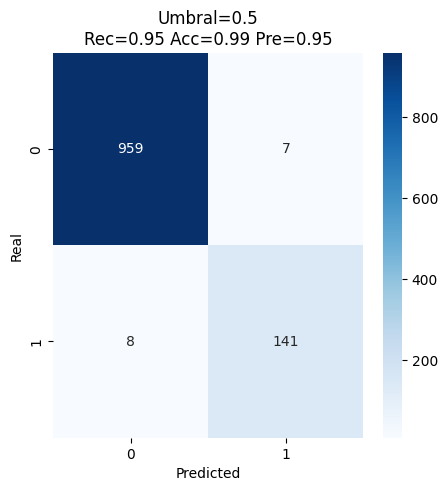

In [ ]:
# Define el umbral de probabilidad para la clasificación. 
# Cualquier probabilidad predicha mayor o igual a 0.5 se considera clase positiva (spam).
umbral=0.5

# Convierte las probabilidades predichas (y_pred_probs) en etiquetas binarias (0 o 1) 
# usando el umbral definido.
y_pred=y_pred_probs[:]>=umbral

# Crea un objeto figura y un conjunto de ejes (subplots) para el gráfico.
fig, axes = plt.subplots(1,1)

# Establece el tamaño de la figura en 5x5 pulgadas.
fig.set_size_inches(5, 5)

# Calcula la Matriz de Confusión, comparando las etiquetas reales (y_val) con las etiquetas predichas (y_pred).
matriz = confusion_matrix(y_val, y_pred)

# Asigna los ejes a la variable 'ax' para facilitar su uso.
ax=axes

# Crea un mapa de calor (heatmap) para visualizar la matriz de confusión.
# annot=True: Muestra el valor numérico en cada celda.
# cmap="Blues": Usa la paleta de colores azul.
# fmt="d": Formatea los números como enteros decimales.
sns.heatmap(matriz, annot=True, ax = ax, cmap="Blues",fmt="d");

# Establece el título del gráfico.
# Muestra el valor del umbral y las métricas de Recall, Accuracy y Precision redondeadas a dos decimales.
ax.set_title("Umbral="+str(umbral)+"\nRec="+str(round(recall_score(y_val, y_pred),2))+
" Acc="+str(round(accuracy_score(y_val, y_pred),2))+
" Pre="+str(round(precision_score(y_val, y_pred),2)))

# Etiqueta el eje X como 'Predicted' (Predicción del modelo).
axes.set_xlabel('Predicted')

# Etiqueta el eje Y como 'Real' (Valor verdadero).
axes.set_ylabel('Real')